In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.functional as F 
import torch.nn as nn 
import torch 

# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.decomposition import PCA

from sklearn import metrics

import sklearn as skl

# Data Loading

In [16]:
# Load all data
train_data = pd.read_csv("training_labse.csv")
test_data = pd.read_csv("test_labse.csv")
validation_data = pd.read_csv("validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train + Y_test])

In [36]:
# Perform pre-processing PCA on the training set
pca = PCA()

# Need to standardize the data frirst
standardized = (X_train - X_train.mean(axis=0)) / X_train.std(axis = 0)
pca.fit(X=standardized)

# Tune no. of components via explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

desired_variance = 0.95  # adjust this as needed
n_components = np.argmax(cumulative_variance >= desired_variance) + 1

pca = PCA(n_components=cumulative_variance[n_components])
# currently reduces from 768 params to 182 - given desired_variance = 0.95
X_reduced = pca.fit_transform(X=standardized)
# X_train_d = pca.transform(X=standardized)

X_reduced.shape

[5.40180105e-02 2.43219329e-02 2.27638427e-02 2.05696552e-02
 1.89749599e-02 1.77353141e-02 1.59488264e-02 1.50777527e-02
 1.44947000e-02 1.37974154e-02 1.36144746e-02 1.32250621e-02
 1.26756744e-02 1.24632764e-02 1.23302771e-02 1.20868962e-02
 1.10073882e-02 1.06895793e-02 1.06547852e-02 1.04478189e-02
 1.02786705e-02 1.01909981e-02 9.85848895e-03 9.74021630e-03
 9.43799546e-03 9.32514732e-03 9.02340659e-03 8.86333400e-03
 8.60674536e-03 8.47066686e-03 8.32882112e-03 8.18813575e-03
 7.86204188e-03 7.84765246e-03 7.76453955e-03 7.54798161e-03
 7.46967417e-03 7.25135232e-03 7.14804105e-03 7.07290033e-03
 6.96002696e-03 6.92157578e-03 6.76770438e-03 6.70835408e-03
 6.63991311e-03 6.43622099e-03 6.28967680e-03 6.21826690e-03
 6.15986757e-03 6.10865731e-03 5.97185321e-03 5.85570144e-03
 5.74857433e-03 5.72477688e-03 5.65555177e-03 5.54679334e-03
 5.49203698e-03 5.45364515e-03 5.33139212e-03 5.27649765e-03
 5.24443394e-03 5.14178920e-03 5.02219897e-03 4.97715770e-03
 4.97532783e-03 4.867105

(16000, 182)

In [25]:
x = np.array([[1, 2, 3], [4, 5, 6]])
print((x - x.mean(axis = 0)))
print(x.std(axis = 0))

[[-1.5 -1.5 -1.5]
 [ 1.5  1.5  1.5]]
[1.5 1.5 1.5]


# Decision Trees

In [ ]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'best',
    max_depth = 5
)


[Text(0.5, 0.9166666666666666, 'x[323] <= -0.039\nentropy = 2.272\nsamples = 16000\nvalue = [4666, 5362, 1304, 2159, 1937, 572]'),
 Text(0.25, 0.75, 'x[613] <= -0.048\nentropy = 2.274\nsamples = 10036\nvalue = [3583, 2370, 570, 1612, 1512, 389]'),
 Text(0.125, 0.5833333333333334, 'x[151] <= -0.033\nentropy = 2.214\nsamples = 5472\nvalue = [2050, 897, 228, 1111, 1035, 151]'),
 Text(0.0625, 0.4166666666666667, 'x[332] <= 0.012\nentropy = 2.103\nsamples = 2941\nvalue = [1156, 310, 65, 624, 706, 80]'),
 Text(0.03125, 0.25, 'x[190] <= -0.004\nentropy = 2.174\nsamples = 1531\nvalue = [483, 210, 43, 283, 472, 40]'),
 Text(0.015625, 0.08333333333333333, 'entropy = 2.112\nsamples = 654\nvalue = [160, 112, 21, 70, 272, 19]'),
 Text(0.046875, 0.08333333333333333, 'entropy = 2.129\nsamples = 877\nvalue = [323, 98, 22, 213, 200, 21]'),
 Text(0.09375, 0.25, 'x[0] <= -0.039\nentropy = 1.945\nsamples = 1410\nvalue = [673, 100, 22, 341, 234, 40]'),
 Text(0.078125, 0.08333333333333333, 'entropy = 1.297\

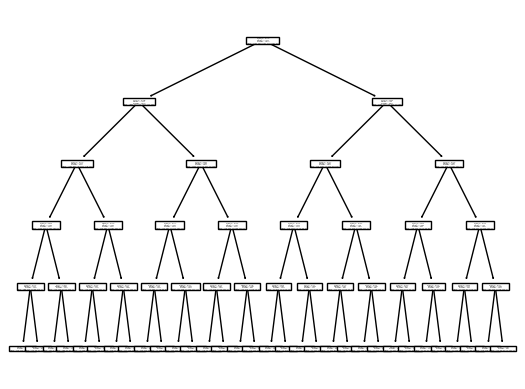

In [ ]:
decision_tree_model.fit(X_train, Y_train)
tree.plot_tree(decision_tree_model)

# SVMs

In [45]:
svm_classifier = svm.SVC(kernel='sigmoid') # 'precomputed', 'linear', 'poly', 'sigmoid', 'rbf'

#Train the model using the training sets
svm_classifier.fit(X_train, Y_train)

#Predict the response for test dataset
Y_pred = svm_classifier.predict(X_test)

In [46]:

print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Linear = 0.64
# rbf = 0.659
# poly = 0.662
# sigmoid = 0.6235


Accuracy: 0.6235


# MLP

# RNN

# Encoder-Only Transformer

# Test

In [ ]:
model_to_test = decision_tree_model

In [ ]:
#TODO: Add stuff for running the test set on the model

# K Folds Cross Validation